In [18]:
import numpy as np
import matplotlib.pyplot as plt
from generator import Croupier

Импортируем класс Croupier, который отвечает за генерацию данных и создадим экземпляр класса с заданными значениями вероятности для нечестного кубика, а так же вероятности перехода с честного кубика на нечестный и на себя самого, и вероятности перехода с нечестного кубика на себя и на честный. Проверим что получаем выпавшие знаечение кубика, а так же метку кубика

In [13]:
casino = Croupier([0.1,0.1,0.1,0.1,0.1,1/2],[0.05,0.95],[0.9,0.1])
for i in range(10):
    print(casino())

(5, 'F')
(1, 'F')
(3, 'U')
(6, 'U')
(5, 'U')
(1, 'U')
(6, 'U')
(6, 'F')
(5, 'F')
(3, 'F')


Сгенерируем датасеты размером 1 000, 10 000 и 100 000

In [182]:
dataset100 = []
dataset100Labels = []

for i in range(100):
    data, label = casino()
    dataset100.append(data)
    dataset100Labels.append(label)

In [14]:
dataset300 = []
dataset300Labels = []

casino = Croupier([0.1,0.1,0.1,0.1,0.1,1/2],[0.05,0.95],[0.9,0.1])

for i in range(300):
    data, label = casino()
    dataset300.append(data)
    dataset300Labels.append(label)

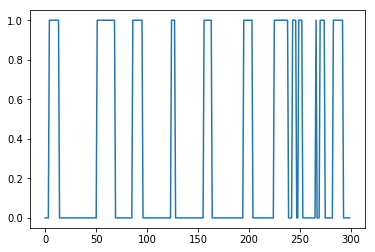

In [19]:
lab = [0 if l =='F' else 1 for l in dataset300Labels ]
plt.plot(lab)

In [9]:
datasetbook3 =  [3,1,5,1,1,6,2,4,6,4,4,6,6,4,4,2,4,5,3,1,1,3,2,1,6,3,1,1,6,4,1,5,2,1,3,3,6,2,5,1,4,4,5,4,3,6,3,1,6,5,6,6,2,6,5,6,6,6,6,6,6,5,1,1,6,6,4,5,3,2,1,3,2,6,5,1,2,4,5,6,3,6,6,6,4,6,3,1,6,6,6,3,1,6,2,3,2,6,5,4,5,2,3,6,2,6,6,6,6,6,6,2,5,1,5,1,6,3,1,2,2,2,5,5,5,4,4,1,6,6,6,5,6,6,5,6,3,5,6,4,3,2,4,3,6,4,1,3,1,5,1,3,4,6,5,1,4,6,3,5,3,4,1,1,1,1,2,6,4,1,4,6,2,6,2,5,3,3,5,6,3,6,6,1,6,3,6,6,6,4,6,6,2,3,2,5,3,4,4,1,3,6,6,1,6,6,1,1,6,3,2,5,2,5,6,2,4,6,2,2,5,5,2,6,2,5,2,2,6,6,4,3,5,3,5,3,5,3,3,3,3,6,1,2,2,1,2,1,6,2,5,3,6,4,4,1,4,4,3,2,3,3,5,1,6,3,2,4,3,6,3,3,3,6,6,6,5,5,6,2,4,6,6,6,6,6,6,2,6,6,6,1,2,3,5,4,5,2,4,2]

In [98]:
dataset1000 = []
dataset1000Labels = []

for i in range(1000):
    data, label = casino()
    dataset1000.append(data)
    dataset1000Labels.append(label)

In [30]:
dataset10000 = []
dataset10000Labels = []

for i in range(10000):
    data, label = casino()
    dataset10000.append(data)
    dataset10000Labels.append(label)

In [31]:
dataset100000 = []
dataset100000Labels = []

for i in range(100000):
    data, label = casino()
    dataset100000.append(data)
    dataset100000Labels.append(label)

Определим базовый класс алгоритма

In [34]:
class baseAlgo():
    def __init__(self, data, fairDiceStateProbability,
                 unfairDiceStateProbability, unfairDice, fairDice = None):
        self.data = data
        self.L = len(data)
        
        #if fairDice == None: self.fairDice = np.log([1/6 for i in range(6)])
        #else: self.fairDice = np.log(fairDice)
        #self.unfairDice = np.log(unfairDice)
         
        #self.toFairState = np.log([fairDiceStateProbability[0],unfairDiceStateProbability[0]])
        #self.toUnfariState = np.log([fairDiceStateProbability[1],unfairDiceStateProbability[1]])
        
        #self.fairDiceStateProbability = np.log(fairDiceStateProbability)
        #self.unfairDiceStateProbability = np.log(unfairDiceStateProbability)
        
        if fairDice == None: self.fairDice = np.array([1/6 for i in range(6)])
        else: self.fairDice = np.array(fairDice)
        self.unfairDice = np.array(unfairDice)
         
        self.toFairState = np.array([fairDiceStateProbability[0],unfairDiceStateProbability[0]])
        self.toUnfariState = np.array([fairDiceStateProbability[1],unfairDiceStateProbability[1]])
        
        self.fairDiceStateProbability = np.array(fairDiceStateProbability)
        self.unfairDiceStateProbability = np.array(unfairDiceStateProbability)
        
        self.states = ['Fair','Unfair']
        self.dices = [self.fairDice,self.unfairDice]
        self.transitions = [self.toFairState, self.toUnfariState]

In [35]:
class algorithmViterbi(baseAlgo):
    def __init__(self, data, fairDiceStateProbability,
                 unfairDiceStateProbability, unfairDice, fairDice = None):
        baseAlgo.__init__(self, data, fairDiceStateProbability,
                 unfairDiceStateProbability, unfairDice, fairDice = None)
        
        self.v = None
        self.ptr = None
        self.path = None

    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        previuosState = self.v[index-1]
        for transitionProbability, probability in zip(self.transitions, self.dices):
            observedProbability = probability[self.data[index]-1]
            #print("PROBABILITY IN CURRENT STATE {}".format(probability))
            #print("DATA {} :PROBABILITY IN CURRENT STATE {}".format(self.data[index],observedProbability))
            
            thisProbability = observedProbability * np.max(previuosState*transitionProbability)
            ptr = 'F' if np.argmax(previuosState*transitionProbability) == 0 else 'U'
            
            #print("TRANSITION PROBABILITY: {}".format(transitionProbability))
            
            #thisProbability = observedProbability + np.max(previuosState + transitionProbability)
            #ptr = 'F' if np.argmax(previuosState + transitionProbability) == 0 else 'U'
            #print('PTR: {}'.format(previuosState + transitionProbability))
            
            self.v[-1].append(thisProbability)
            self.ptr[-1].append(ptr)
            
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path
        
        
    def initialization(self):
        
        self.ptr = []
        self.v = []
        self.path = []
        
        self.v.append([1,0]) # Не уверен
        
        # Рекурсия
        for i in range(1,self.L):
            self.step(i)
            #print('PTR, V: {} _ {}'.format(self.ptr[i-1], self.v[i]))
                
        # Завершение
        self.Probability = max(self.v[-1])
        ptr, index = ('F', 0) if np.argmax(self.v[-1]) == 0 else ('U', 1)
        #print("PTR,INDEX: {} _ {}".format(ptr, index))
        self.path.append(ptr)
        
        # Обратный ход
        for step in range(self.L - 2,0,-1):
            ptr, index = ('F', 0) if self.ptr[step][index] == 'F' else ('U', 1)
            #print(self.ptr[step])
            #print(self.v[step])
            #print("Step {} : PTR,INDEX: {} _ {}".format(step,ptr, index))
            self.path.append(ptr)
        self.path = self.path[::-1]
        
    def probability(self):
        return np.e**self.Probability

In [36]:
testData = [1,2,4,2,6,6,6,1,6] # F,F,F,F,U,U,U,U,U

In [37]:
hackCasinoViterbi = algorithmViterbi(testData, [0.95,0.05],[0.1,0.9],[0.1,0.1,0.1,0.1,0.1,1/2])
result = hackCasinoViterbi()
hackCasinoViterbi.probability()
result

['F', 'F', 'F', 'U', 'U', 'U', 'U', 'U']

In [38]:
testData2 = [1,2,4,2,6,6,6,1,6,2,5,6,6,6,6,6,6,6] # F,F,F,F,U,U,U,U,U,F,U,U,U
hackCasinoViterbi = algorithmViterbi(testData2, [0.95,0.05],[0.1,0.9],[0.1,0.1,0.1,0.1,0.1,1/2])
result = hackCasinoViterbi()
hackCasinoViterbi.probability()
result

['F',
 'F',
 'F',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U',
 'U']

In [11]:
hackCasinoViterbi = algorithmViterbi(datasetbook3, [0.95,0.05],[0.1,0.9],[0.1,0.1,0.1,0.1,0.1,1/2])
result = hackCasinoViterbi()
hackCasinoViterbi.probability()
#result

1.0

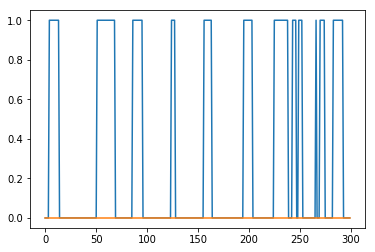

In [39]:
hackCasinoViterbi = algorithmViterbi(dataset300, [0.95,0.05],[0.1,0.9],[0.1,0.1,0.1,0.1,0.1,0.5])
result = hackCasinoViterbi()
# hackCasinoViterbi.probability()
# print(result)
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab)
plt.plot(res)

In [189]:
print(dataset1000Labels)

['U', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'F', 'F', 'F', 'F', 'U', 'F', 'F', 'F', 'F', 'U', 'U', 'U', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'U', 'U', 'U', 'U', 'U', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'U', 'U', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'U', 'U', 'U', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'U', 'U', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',

In [26]:
class forwardAlgorithm(baseAlgo):
    def __init__(self, data, fairDiceStateProbability,
                 unfairDiceStateProbability, unfairDice, fairDice = None):
        baseAlgo.__init__(self, data, fairDiceStateProbability,
                 unfairDiceStateProbability, unfairDice, fairDice = None)
        
        self.f = np.array([])
        self.pathProbability = None
    
    def step(self, index):
        self.f.append([])
        for transitionProbability, probability in zip(self.transitions, self.dices):
            observedProbability = probability[self.data[index]]
            previuosState = self.f[index-1]
            """
            observedProbability: вероятсность наблюдения при текущем состояние
            transitionProbability: вероятность перехода с кубика на кубик
            """
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        # Init
        self.f.append([1,0]) # Не уверен
        # Recursion
        for i in range(1,self.L):
            self.step(i)
        self.pathProbability = sum(self.f[-1])

In [ ]:
hackCasino = 

In [27]:
class backwardAlgorithm(baseAlgo):
    def __init__(self, data, fairDiceStateProbability,
                 unfairDiceStateProbability, unfairDice, fairDice = None):
        baseAlgo.__init__(self, data, fairDiceStateProbability,
                 unfairDiceStateProbability, unfairDice, fairDice = None)
        
        self.b = np.array([])
        self.pathProbability = None
    
    def step(self, index):
        self.b.append([])
        for transitionProbability in self.transitions: # first fair then unfair
            observedProbability = np.array([])
            for probability in self.dices
                observedProbability.append(probability[self.data[index]])
            nextState = self.b[index-1]
            
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        #Init self.L - 1 КАК ИНИЦИАОИЗИРОВАТЬ?
        pass
        #Recursion
        for i in range(2,self.L): # С двойки?
            self.step(i)
        # Finish # перевернуть b
        self.b = self.b[::-1]
        pass

In [11]:
a = np.array([,1/2])
np.log(a)

array([-0.69314718, -0.69314718])